In [96]:
import pandas as pd
%pip install matplotlib
import matplotlib.pyplot as plt


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [97]:
amr = pd.read_csv("/Users/admin/AMR/data/cleaned/amr_cleaned.csv")

In [98]:
amr.head()


,geography,stratum,date,resistance_pct,organism
0,East Midlands,Glycopeptides,2020-08-01,22.67,e_faecalis
1,East Midlands,Glycopeptides,2020-09-01,20.67,e_faecalis
2,East Midlands,Glycopeptides,2020-10-01,18.67,e_faecalis
3,East Midlands,Glycopeptides,2020-11-01,22.00,e_faecalis
4,East Midlands,Glycopeptides,2020-12-01,24.67,e_faecalis


In [99]:
# ensure data is datetime

amr["date"] = pd.to_datetime(amr["date"])


In [100]:
amr.dtypes

geography                 object
stratum                   object
date              datetime64[ns]
resistance_pct           float64
organism                  object
dtype: object

In [101]:
amr["stratum"].dtype

dtype('O')

In [102]:
amr = amr.sort_values(
    ["organism", "geography", "stratum", "date"]
).reset_index(drop=True)

In [103]:
amr

,geography,stratum,date,resistance_pct,organism
0,East Midlands,Glycopeptides,2020-08-01,22.67,e_faecalis
1,East Midlands,Glycopeptides,2020-09-01,20.67,e_faecalis
2,East Midlands,Glycopeptides,2020-10-01,18.67,e_faecalis
3,East Midlands,Glycopeptides,2020-11-01,22.00,e_faecalis
4,East Midlands,Glycopeptides,2020-12-01,24.67,e_faecalis
...,...,...,...,...,...
11140,Yorkshire and Humber,Penicillin,2025-02-01,0.85,s_pneumoniae
11141,Yorkshire and Humber,Penicillin,2025-03-01,2.22,s_pneumoniae
11142,Yorkshire and Humber,Penicillin,2025-04-01,1.18,s_pneumoniae
11143,Yorkshire and Humber,Penicillin,2025-05-01,3.65,s_pneumoniae


Create One time series 

In [104]:
sample = amr [
    (amr["organism"] == "e_faecalis") &
    (amr["geography"] == "East Midlands") &
    (amr["stratum"] == "Glycopeptides")
]
series = sample.set_index("date")["resistance_pct"]
series.head()

date
2020-08-01    22.67
2020-09-01    20.67
2020-10-01    18.67
2020-11-01    22.00
2020-12-01    24.67
Name: resistance_pct, dtype: float64

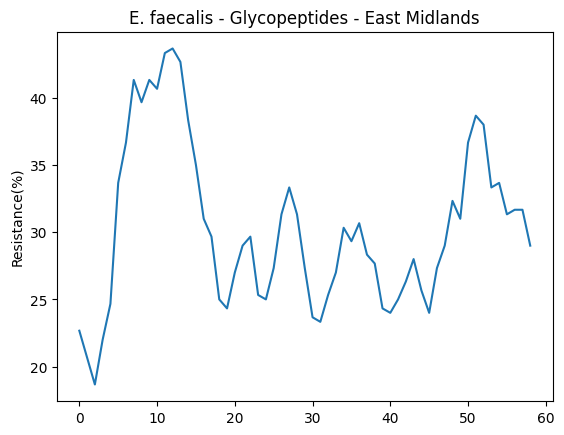

In [105]:
sample["resistance_pct"].plot(
    title="E. faecalis - Glycopeptides - East Midlands"
)
plt.ylabel("Resistance(%)")
plt.show()

In [106]:
%pip install statsmodels
from statsmodels.tsa.stattools import adfuller



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Check Stationarity

In [107]:
# using ADF test to ensure that the time series is non-stationary
# ADF has a null hypothesis that the time series is non-stationary
# a small p - value -> less than 0.05 == rejected null hypo and means data is stationary

adf = adfuller(series.dropna())
print("ADF statistic", adf[0])
print("p-value:", adf[1])


ADF statistic -2.9413776980357915
p-value: 0.040743590890547084


Reveal Structure of time-series using ACF and PACF

In [108]:
series.isna().sum()

np.int64(0)

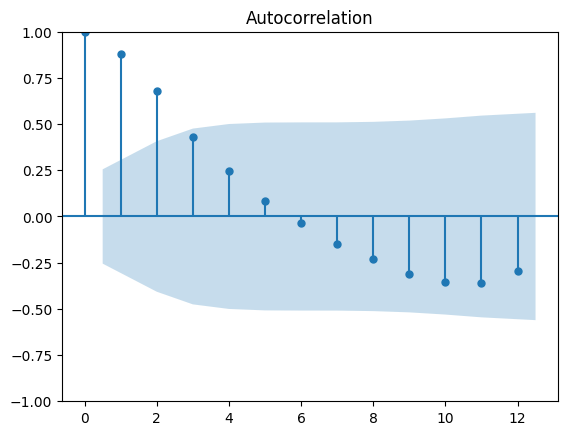

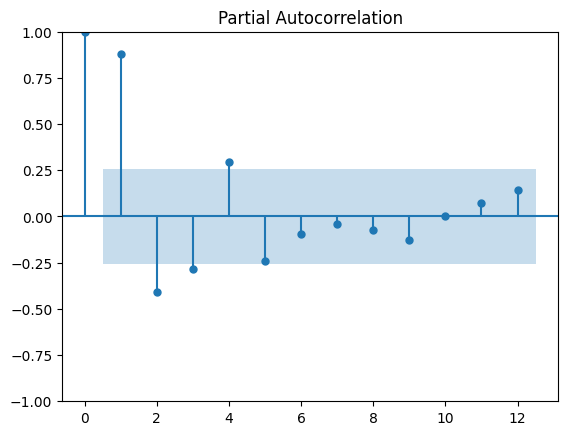

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series, lags=12) #q
plt.show()
plot_pacf(series, lags=12) #p
plt.show()

#PACF: significant spikes at lag 1 and lag 2 , 
#ACF: significant spikes at lag 1 and lag 2
# After lag 2 → mostly inside confidence bounds (noise)

In [110]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(series, order=(1,1,0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:         resistance_pct   No. Observations:                   59
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -138.810
Date:                Sun, 11 Jan 2026   AIC                            281.620
Time:                        20:27:11   BIC                            285.741
Sample:                    08-01-2020   HQIC                           283.225
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3431      0.171      2.009      0.045       0.008       0.678
sigma2         7.0042      1.322      5.299      0.000       4.413       9.595
Ljung-Box (L1) (Q):                   0.07   Jarque-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


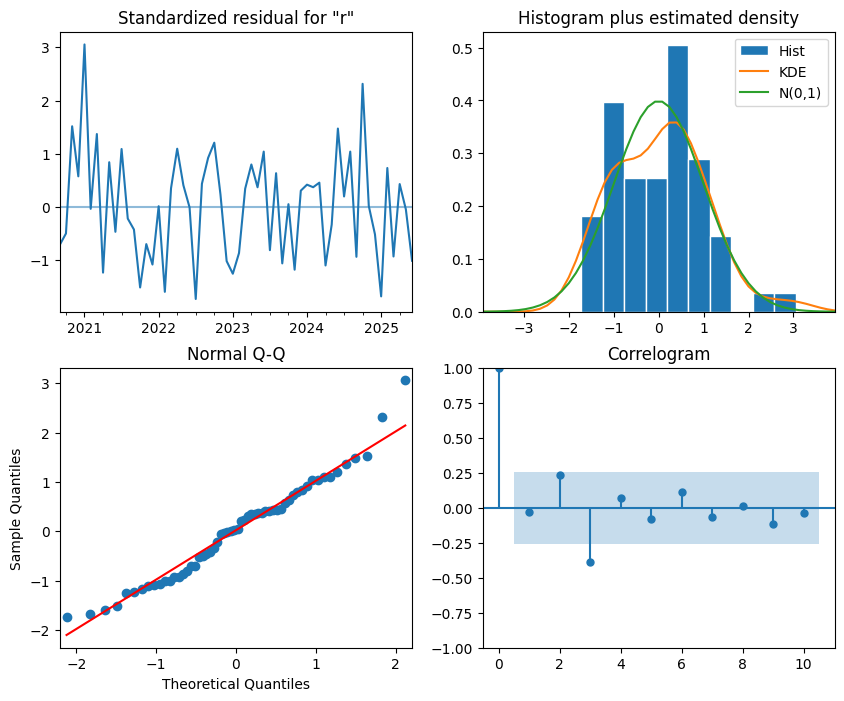

In [111]:
results.plot_diagnostics(figsize=(10, 8))
plt.show()

In [112]:
series


date
2020-08-01    22.67
2020-09-01    20.67
2020-10-01    18.67
2020-11-01    22.00
2020-12-01    24.67
2021-01-01    33.67
2021-02-01    36.67
2021-03-01    41.33
2021-04-01    39.67
2021-05-01    41.33
2021-06-01    40.67
2021-07-01    43.33
2021-08-01    43.67
2021-09-01    42.67
2021-10-01    38.33
2021-11-01    35.00
2021-12-01    31.00
2022-01-01    29.67
2022-02-01    25.00
2022-03-01    24.33
2022-04-01    27.00
2022-05-01    29.00
2022-06-01    29.67
2022-07-01    25.33
2022-08-01    25.00
2022-09-01    27.33
2022-10-01    31.33
2022-11-01    33.33
2022-12-01    31.33
2023-01-01    27.33
2023-02-01    23.67
2023-03-01    23.33
2023-04-01    25.33
2023-05-01    27.00
2023-06-01    30.33
2023-07-01    29.33
2023-08-01    30.67
2023-09-01    28.33
2023-10-01    27.67
2023-11-01    24.33
2023-12-01    24.00
2024-01-01    25.00
2024-02-01    26.33
2024-03-01    28.00
2024-04-01    25.67
2024-05-01    24.00
2024-06-01    27.33
2024-07-01    29.00
2024-08-01    32.33
2024-09-01    3

In [113]:
train = series[: "2024-06-01"]
test = series["2024-07-01": ]

In [114]:
model = ARIMA(train, order=(1,1,0))
results = model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast the test period

In [115]:
forecast = results.forecast(steps=len(test))
forecast.index = test.index

In [116]:
%pip install numpy


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [117]:
%pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE", rmse )


MAE: 3.6729005840501414
RMSE 4.66028323648673


Text(0.5, 1.0, 'ARIMA Forecast vs Actual')

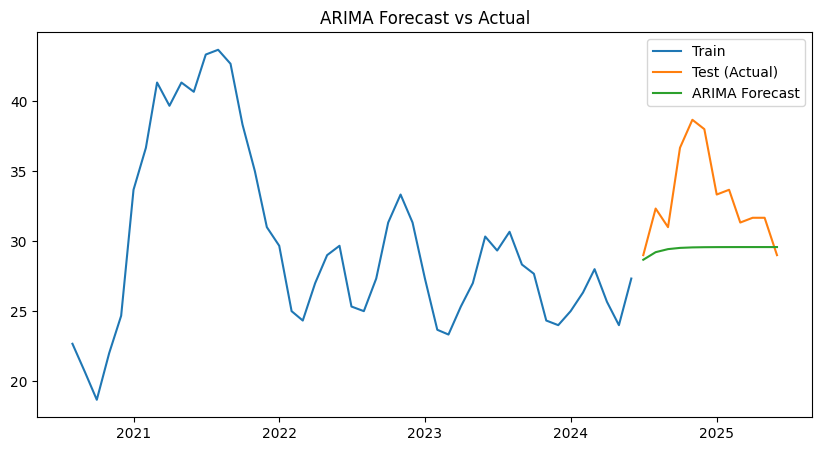

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label = "Train")
plt.plot(test.index, test, label = "Test (Actual)")
plt.plot(forecast.index, forecast, label= "ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")